In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns
import time
import os
import sys

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping

sys.path.append(os.path.abspath('../Data'))
import queries

In [2]:
server = 'VT3'
schema = 'WCS01600'
features = queries.get_profit_ces_by_month(server, schema)
print(features.astype(int))

    TYEAR  TMON   PROFIT     CES
0    2016     1  3161099  617609
1    2016     2  3504541  672058
2    2016     3  4217011  811095
3    2016     4  4019067  768832
4    2016     5  5117128  967048
..    ...   ...      ...     ...
56   2020     9  5571738  952390
57   2020    10  4872235  852502
58   2020    11  4243951  751612
59   2020    12  4990264  882340
60   2021     1       10       3

[61 rows x 4 columns]


array([[<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],


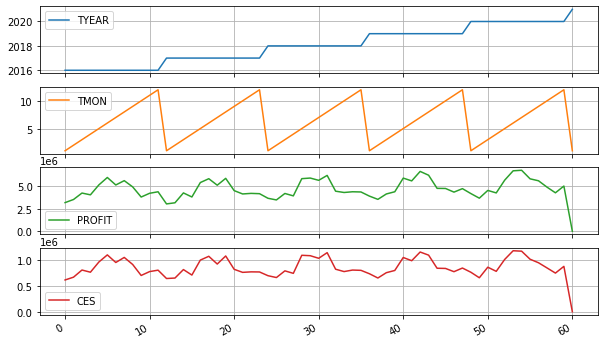

In [3]:
features.plot(subplots=True, grid=True, layout=(features.shape[0], 1), figsize=(10, 100))

In [4]:
def year_month_to_date(df):
    df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH'})
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
    df = df.drop(columns=['YEAR', 'MONTH'])
    df.set_index('DATE', inplace=True)
    return df

In [5]:
new_features = year_month_to_date(features)

In [6]:
### Normalization
scaler = MinMaxScaler(feature_range=(0,1))
print(new_features.values.shape)
scaled_new_features = pd.DataFrame(scaler.fit_transform(new_features.values), columns=new_features.columns, index=new_features.index)
print(scaled_new_features)

(61, 2)
              PROFIT       CES
DATE                          
2016-01-01  0.469458  0.520663
2016-02-01  0.520463  0.566565
2016-03-01  0.626273  0.683779
2016-04-01  0.596876  0.648149
2016-05-01  0.759950  0.815252
...              ...       ...
2020-09-01  0.827465  0.802895
2020-10-01  0.723581  0.718686
2020-11-01  0.630274  0.633632
2020-12-01  0.741110  0.743840
2021-01-01  0.000000  0.000000

[61 rows x 2 columns]


In [7]:
### To Supervised (lag values)
lags = range(1, 2, 1)
cols = new_features.columns

supervised = scaled_new_features.assign(**{
    '{} (t-{})'.format(col, t): scaled_new_features[col].shift(t)
    for t in lags
    for col in cols
})[1:]
print(supervised)


              PROFIT       CES  PROFIT (t-1)  CES (t-1)
DATE                                                   
2016-02-01  0.520463  0.566565      0.469458   0.520663
2016-03-01  0.626273  0.683779      0.520463   0.566565
2016-04-01  0.596876  0.648149      0.626273   0.683779
2016-05-01  0.759950  0.815252      0.596876   0.648149
2016-06-01  0.881567  0.931985      0.759950   0.815252
2016-07-01  0.758751  0.807531      0.881567   0.931985
2016-08-01  0.829531  0.890402      0.758751   0.807531
2016-09-01  0.726963  0.774267      0.829531   0.890402
2016-10-01  0.560789  0.594620      0.726963   0.774267
2016-11-01  0.622484  0.658100      0.560789   0.594620
2016-12-01  0.647212  0.681491      0.622484   0.658100
2017-01-01  0.448029  0.544586      0.647212   0.681491
2017-02-01  0.466563  0.552215      0.448029   0.544586
2017-03-01  0.628409  0.691232      0.466563   0.552215
2017-04-01  0.561824  0.601227      0.628409   0.691232
2017-05-01  0.798413  0.846753      0.561824   0

In [19]:
NUM_SAMPLES = supervised.shape[0]
TEST_PCT = 0.15
TEST_SIZE = int(NUM_SAMPLES * TEST_PCT)
TRAIN_SIZE = NUM_SAMPLES - TEST_SIZE
train = supervised.values[:TRAIN_SIZE, :]
test = supervised.values[:TEST_SIZE, :]
# Inputs and Outputs
X_train, Y_train = train[:, 1:], train[:, 0]
X_test, Y_test = test[:, 1:], test[:, 0]
# Reshape to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print(X_train)
print(Y_train)

(51, 1, 3) (51,) (9, 1, 3) (9,)
[[[0.56656513 0.46945777 0.52066308]]

 [[0.68377869 0.52046283 0.56656513]]

 [[0.64814946 0.62627276 0.68377869]]

 [[0.81525209 0.59687586 0.64814946]]

 [[0.93198523 0.75995044 0.81525209]]

 [[0.80753059 0.88156731 0.93198523]]

 [[0.890402   0.75875098 0.80753059]]

 [[0.77426726 0.82953146 0.890402  ]]

 [[0.59461997 0.72696326 0.77426726]]

 [[0.65810035 0.5607891  0.59461997]]

 [[0.68149125 0.62248421 0.65810035]]

 [[0.54458605 0.6472124  0.68149125]]

 [[0.55221487 0.44802886 0.54458605]]

 [[0.69123182 0.46656306 0.55221487]]

 [[0.60122739 0.62840922 0.69123182]]

 [[0.84675278 0.56182359 0.60122739]]

 [[0.90890009 0.79841329 0.84675278]]

 [[0.78194383 0.86153857 0.90890009]]

 [[0.91414706 0.75494856 0.78194383]]

 [[0.69548664 0.86730053 0.91414706]]

 [[0.64551257 0.66612749 0.69548664]]

 [[0.65365609 0.61139408 0.64551257]]

 [[0.65202618 0.62077511 0.65365609]]

 [[0.59081489 0.61591677 0.65202618]]

 [[0.56046711 0.54045465 0.59081

Epoch 1/200
2/2 - 3s - loss: 0.6553 - val_loss: 0.6495
Epoch 2/200
2/2 - 0s - loss: 0.6343 - val_loss: 0.6282
Epoch 3/200
2/2 - 0s - loss: 0.6133 - val_loss: 0.6068
Epoch 4/200
2/2 - 0s - loss: 0.5922 - val_loss: 0.5852
Epoch 5/200
2/2 - 0s - loss: 0.5710 - val_loss: 0.5636
Epoch 6/200
2/2 - 0s - loss: 0.5496 - val_loss: 0.5418
Epoch 7/200
2/2 - 0s - loss: 0.5281 - val_loss: 0.5198
Epoch 8/200
2/2 - 0s - loss: 0.5064 - val_loss: 0.4975
Epoch 9/200
2/2 - 0s - loss: 0.4844 - val_loss: 0.4750
Epoch 10/200
2/2 - 0s - loss: 0.4622 - val_loss: 0.4522
Epoch 11/200
2/2 - 0s - loss: 0.4397 - val_loss: 0.4291
Epoch 12/200
2/2 - 0s - loss: 0.4168 - val_loss: 0.4056
Epoch 13/200
2/2 - 0s - loss: 0.3936 - val_loss: 0.3817
Epoch 14/200
2/2 - 0s - loss: 0.3700 - val_loss: 0.3574
Epoch 15/200
2/2 - 0s - loss: 0.3459 - val_loss: 0.3326
Epoch 16/200
2/2 - 0s - loss: 0.3214 - val_loss: 0.3073
Epoch 17/200
2/2 - 0s - loss: 0.2964 - val_loss: 0.2815
Epoch 18/200
2/2 - 0s - loss: 0.2708 - val_loss: 0.2550
E

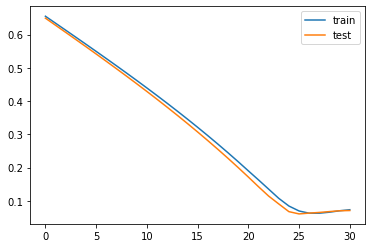

In [9]:
### Model declaration
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=200, callbacks=[early_stopping], validation_data=(X_test, Y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
### Predict
yhat = model.predict(X_test)

0     3161099
1     3504541
2     4217011
3     4019067
4     5117128
       ...   
56    5571738
57    4872235
58    4243951
59    4990264
60         10
Name: PROFIT, Length: 61, dtype: int32
[3581076.08790263 3908135.54292102 4187555.08291791 4349106.97132663
 5036202.97704713 5210154.4878197  4960083.06194272 5009927.57724403
 4398983.59440555]
[3504541.3235 4217011.2887 4019067.6186 5117128.4854 5936034.3359
 5109051.9478 5585651.5039 4895009.6763 3776077.7983]
Test RMSE: 509027.253


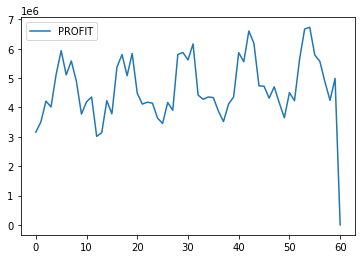

In [18]:
### RMSE Calculation
X_test_og = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((yhat, X_test_og[:, 2:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#
Y_test = Y_test.reshape((len(Y_test), 1))
inv_y = np.concatenate((Y_test, X_test_og[:, 2:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print(features['PROFIT'].astype(int))
print(inv_yhat)
print(inv_y)

features.plot(y='PROFIT', kind='line')

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [12]:
print(X_test)

[[[0.56656513 0.46945777 0.52066308]]

 [[0.68377869 0.52046283 0.56656513]]

 [[0.64814946 0.62627276 0.68377869]]

 [[0.81525209 0.59687586 0.64814946]]

 [[0.93198523 0.75995044 0.81525209]]

 [[0.80753059 0.88156731 0.93198523]]

 [[0.890402   0.75875098 0.80753059]]

 [[0.77426726 0.82953146 0.890402  ]]

 [[0.59461997 0.72696326 0.77426726]]]
